In [1]:
!pip install -Uq watermark

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.6.9
IPython 7.10.2

numpy 1.17.4
pandas 1.0.3
torch 1.2.0+cu92


In [3]:
import os

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [4]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,663,678,712,726,736,750,766,773,782,789
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,723,731,738,738,743,743,743,745,745,747
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,25,25,25,26,27,27,27,27,30,35


In [5]:
df.head(20)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,663,678,712,726,736,750,766,773,782,789
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,723,731,738,738,743,743,743,745,745,747
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,25,25,25,26,27,27,27,27,30,35
5,NaN,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,24,24,24,24,24,24,24,24,25,25
6,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,...,3435,3607,3780,3892,4003,4127,4285,4428,4532,4681
7,NaN,Armenia,40.0691,45.0382,0,0,0,0,0,0,...,1523,1596,1677,1746,1808,1867,1932,2066,2148,2273
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,104,105,106,106,106,106,106,106,106,106
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,2976,2982,2994,3002,3004,3016,3016,3025,3030,3035


In [6]:
df = df.iloc[:, 4:]

In [7]:
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20
0,0,0,0,0,0,0,0,0,0,0,...,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469
1,0,0,0,0,0,0,0,0,0,0,...,663,678,712,726,736,750,766,773,782,789
2,0,0,0,0,0,0,0,0,0,0,...,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295
3,0,0,0,0,0,0,0,0,0,0,...,723,731,738,738,743,743,743,745,745,747
4,0,0,0,0,0,0,0,0,0,0,...,25,25,25,26,27,27,27,27,30,35


In [8]:
df.isnull().sum().sum()

0

In [9]:
df.sum(axis=0)

1/22/20        555
1/23/20        654
1/24/20        941
1/25/20       1434
1/26/20       2118
            ...   
4/28/20    3097190
4/29/20    3172287
4/30/20    3256853
5/1/20     3343777
5/2/20     3427343
Length: 102, dtype: int64

In [10]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555
2020-01-23     654
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

Text(0.5, 1.0, 'Cumulative daily cases')

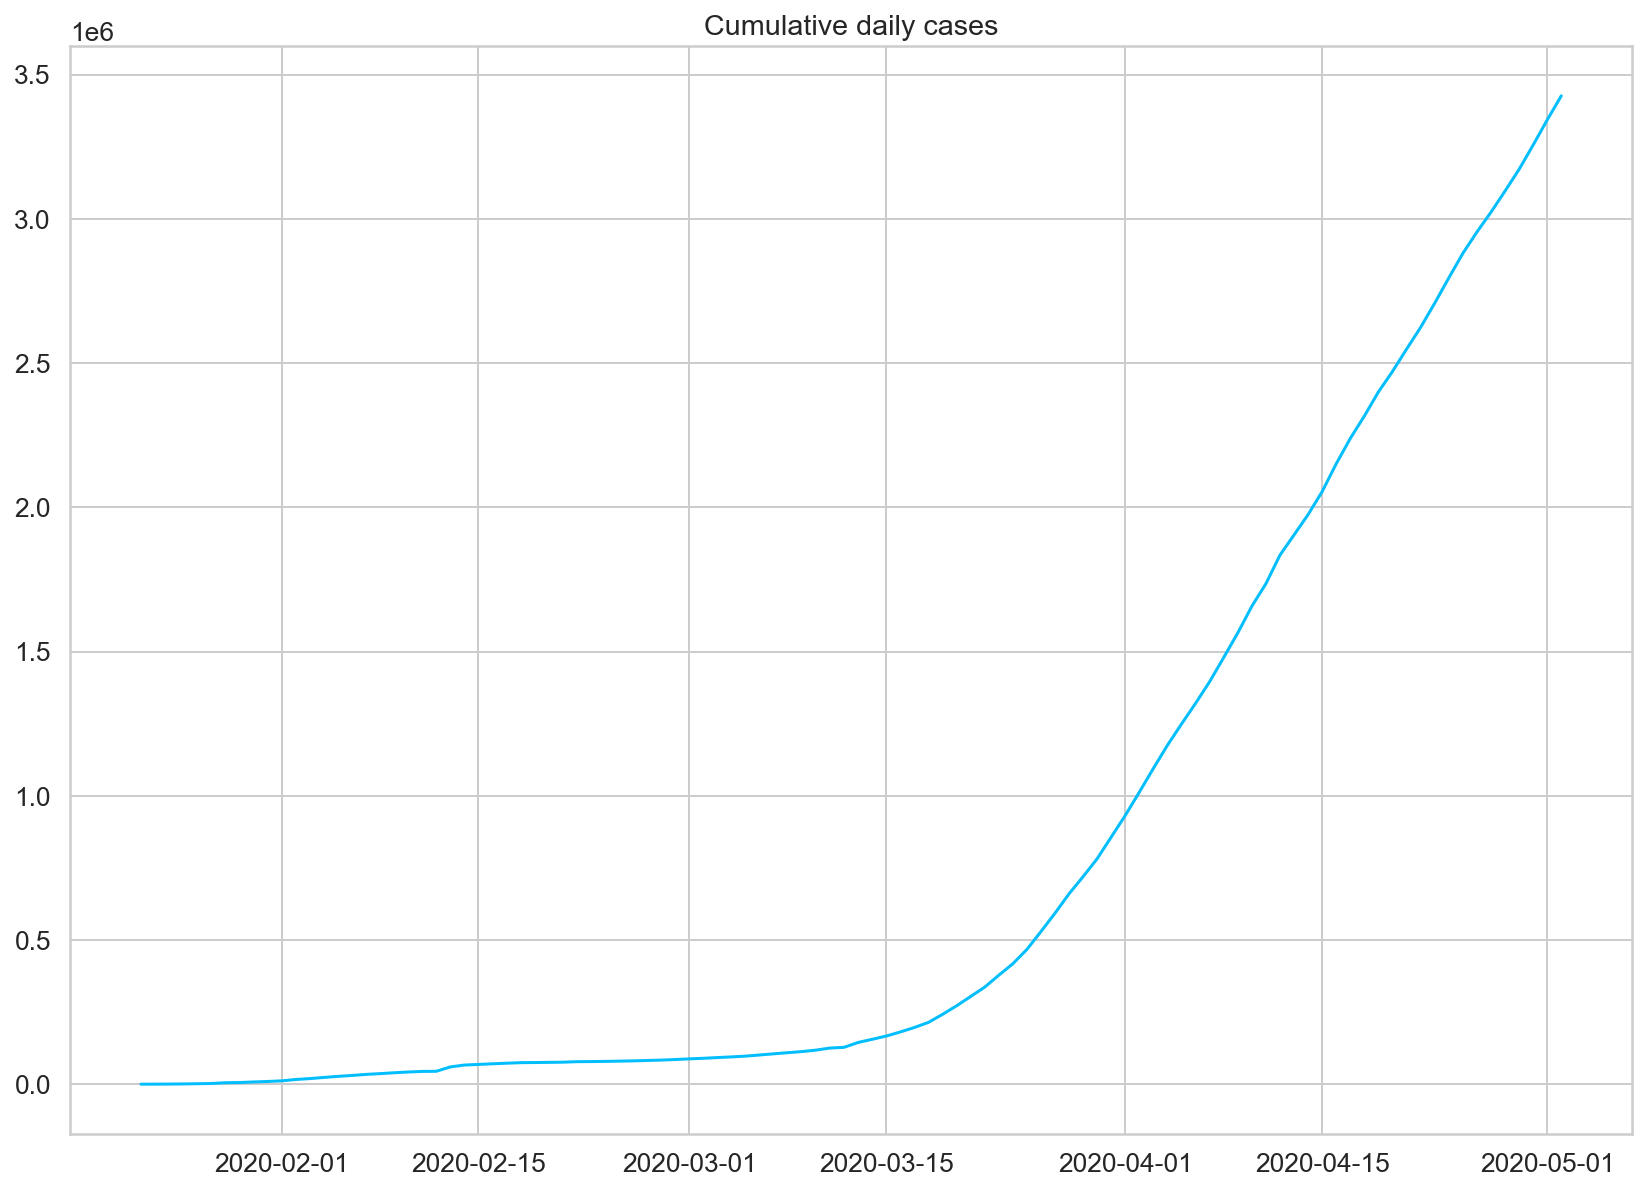

In [11]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases")

In [12]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    555
2020-01-23     99
2020-01-24    287
2020-01-25    493
2020-01-26    684
dtype: int64

Text(0.5, 1.0, 'Daily cases')

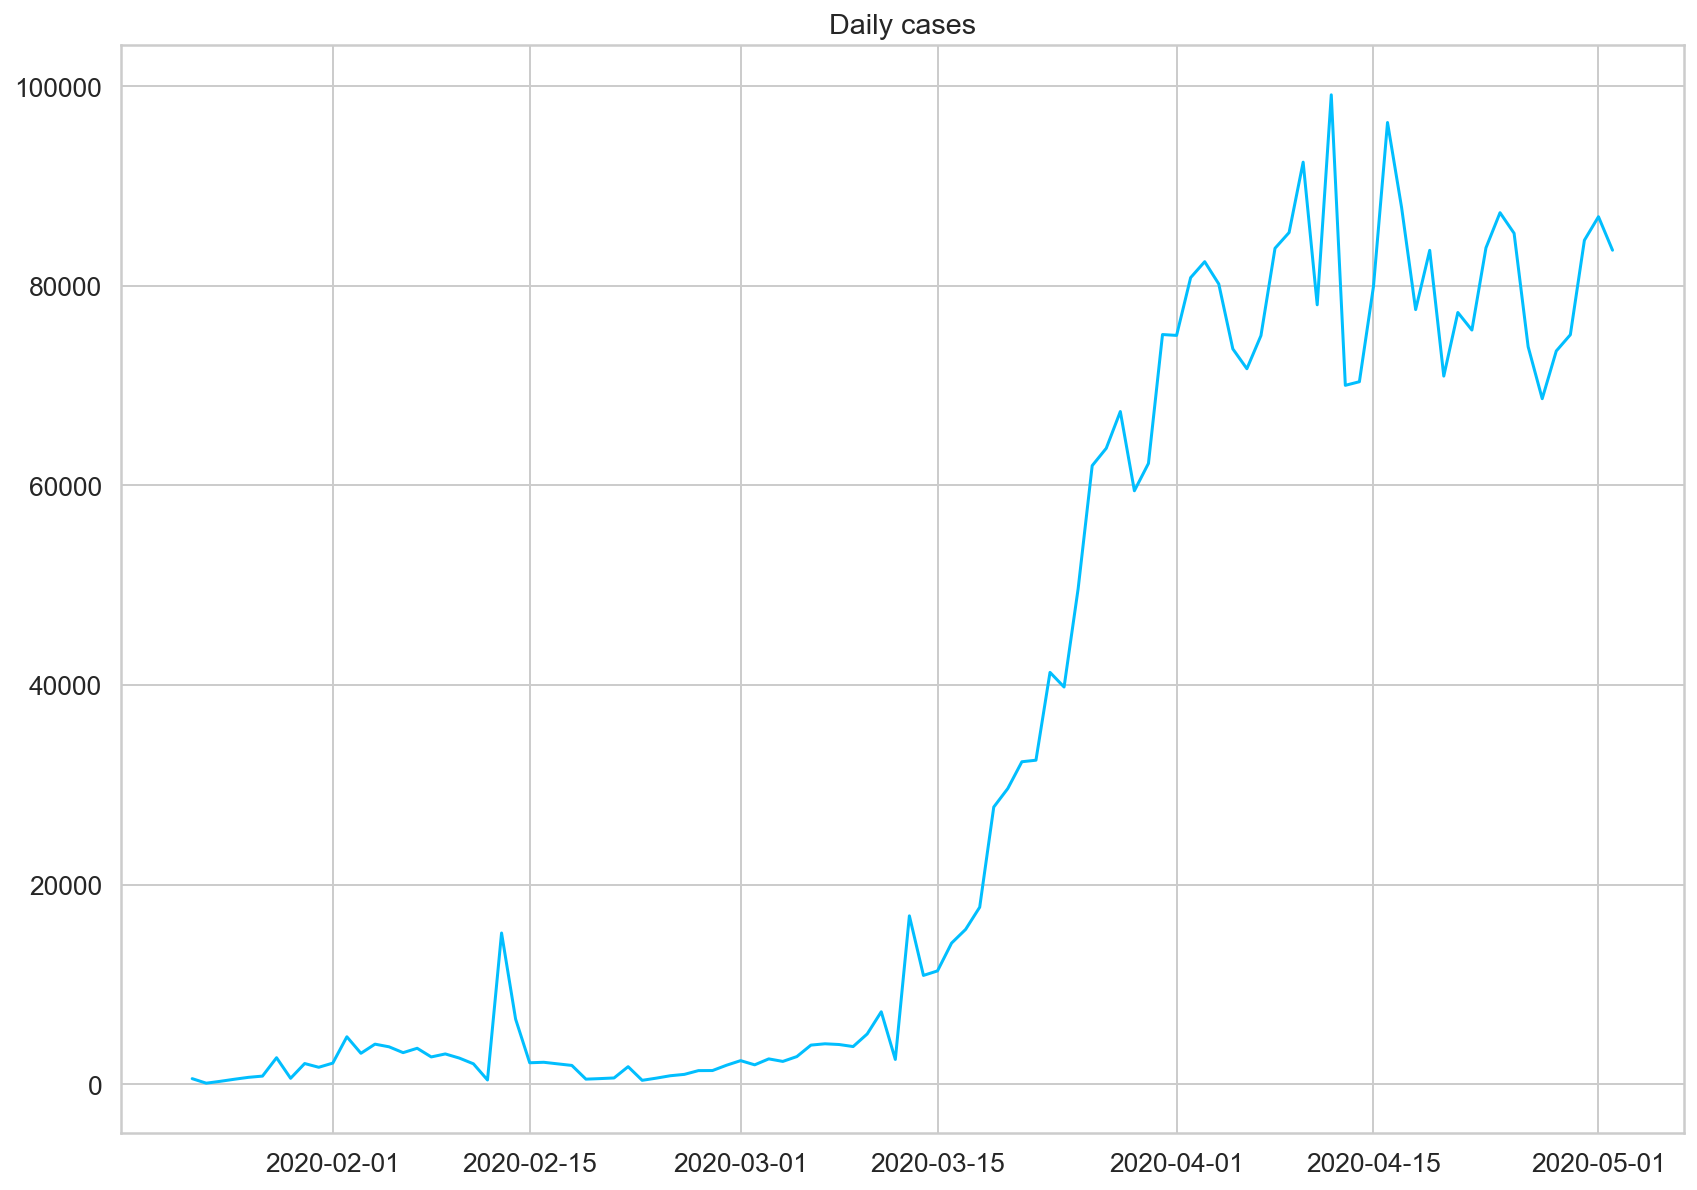

In [13]:
plt.plot(daily_cases)
plt.title("Daily cases")

In [14]:
daily_cases.shape

(102,)

### Preprocessing

In [15]:
test_data_size = 14

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

(88,)

#### Scaling

In [16]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

In [17]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [18]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [19]:
X_train.shape

torch.Size([82, 5, 1])

In [20]:
X_train[:2]

tensor([[[0.0046],
         [0.0000],
         [0.0019],
         [0.0040],
         [0.0059]],

        [[0.0000],
         [0.0019],
         [0.0040],
         [0.0059],
         [0.0072]]])

### Building a model

In [21]:
class CoronaVirusPredictor(nn.Module):
    
    def __init__(self, n_features, n_hidden, seq_len, n_layers=5):
        super(CoronaVirusPredictor, self).__init__()
        
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.2
        )
        self.bn = nn.BatchNorm1d(num_features=1)

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        
        lstm_out, self.hidden = self.lstm(
                                          sequences.view(len(sequences), 
                                          self.seq_len, -1),
                                          self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.bn(self.linear(last_time_step))
        return y_pred

In [22]:
def train_model(model, train_data, train_labels, 
                test_data=None, test_labels=None):

    loss_fn = torch.nn.MSELoss(reduction='sum')
    
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 2000

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(train_data)

        loss = loss_fn(y_pred.float(), train_labels)

        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(test_data)
                test_loss = loss_fn(y_test_pred.float(), test_labels)
            test_hist[epoch] = test_loss.item()
            
            if epoch % 10 == 0:  
                print('Epoch {} train loss: {:.4f} test loss: {:.4f}'.format(epoch, loss.item(), test_loss.item()))
        elif epoch % 10 == 0:
            print('Epoch {} train loss: {:.4f}'.format(epoch, loss.item()))

        train_hist[epoch] = loss.item()

        optimiser.zero_grad()

        loss.backward()

        optimiser.step()

    return model.eval(), train_hist, test_hist

In [23]:
model = CoronaVirusPredictor(n_features=1, n_hidden=2,
                             seq_len=seq_length, n_layers=2)

model, train_hist, test_hist = train_model(model, X_train,
                                           y_train, X_test,
                                           y_test)

Epoch 0 train loss: 34.7733 test loss: 6.8111
Epoch 10 train loss: 23.2562 test loss: 5.3531
Epoch 20 train loss: 13.4218 test loss: 5.1343
Epoch 30 train loss: 12.4056 test loss: 4.9528
Epoch 40 train loss: 11.4775 test loss: 4.7750
Epoch 50 train loss: 9.2333 test loss: 4.6284
Epoch 60 train loss: 9.0584 test loss: 4.5312
Epoch 70 train loss: 9.1090 test loss: 4.4102
Epoch 80 train loss: 8.6997 test loss: 4.3100
Epoch 90 train loss: 8.3627 test loss: 4.1681
Epoch 100 train loss: 8.3653 test loss: 4.1101
Epoch 110 train loss: 8.1594 test loss: 3.9902
Epoch 120 train loss: 7.4974 test loss: 3.9401
Epoch 130 train loss: 6.9166 test loss: 3.8294
Epoch 140 train loss: 7.0829 test loss: 3.7595
Epoch 150 train loss: 6.8627 test loss: 3.6525
Epoch 160 train loss: 6.8588 test loss: 3.6105
Epoch 170 train loss: 6.2794 test loss: 3.5539
Epoch 180 train loss: 6.7053 test loss: 3.4444
Epoch 190 train loss: 5.6315 test loss: 3.4092
Epoch 200 train loss: 5.7616 test loss: 3.3369
Epoch 210 train los

Epoch 1730 train loss: 1.3825 test loss: 2.4084
Epoch 1740 train loss: 1.4015 test loss: 2.3947
Epoch 1750 train loss: 1.3952 test loss: 2.4954
Epoch 1760 train loss: 1.5376 test loss: 3.0649
Epoch 1770 train loss: 1.4018 test loss: 3.1606
Epoch 1780 train loss: 1.0752 test loss: 2.7516
Epoch 1790 train loss: 1.3581 test loss: 2.6523
Epoch 1800 train loss: 1.4852 test loss: 2.9258
Epoch 1810 train loss: 1.5120 test loss: 2.6517
Epoch 1820 train loss: 1.1074 test loss: 2.6336
Epoch 1830 train loss: 1.4314 test loss: 2.6671
Epoch 1840 train loss: 1.3255 test loss: 2.9207
Epoch 1850 train loss: 1.3858 test loss: 2.5019
Epoch 1860 train loss: 1.3126 test loss: 2.6865
Epoch 1870 train loss: 1.3064 test loss: 2.4075
Epoch 1880 train loss: 1.6974 test loss: 2.7025
Epoch 1890 train loss: 1.4713 test loss: 2.4174
Epoch 1900 train loss: 1.1901 test loss: 2.5643
Epoch 1910 train loss: 1.7808 test loss: 2.8794
Epoch 1920 train loss: 1.2534 test loss: 2.6767
Epoch 1930 train loss: 1.2078 test loss:

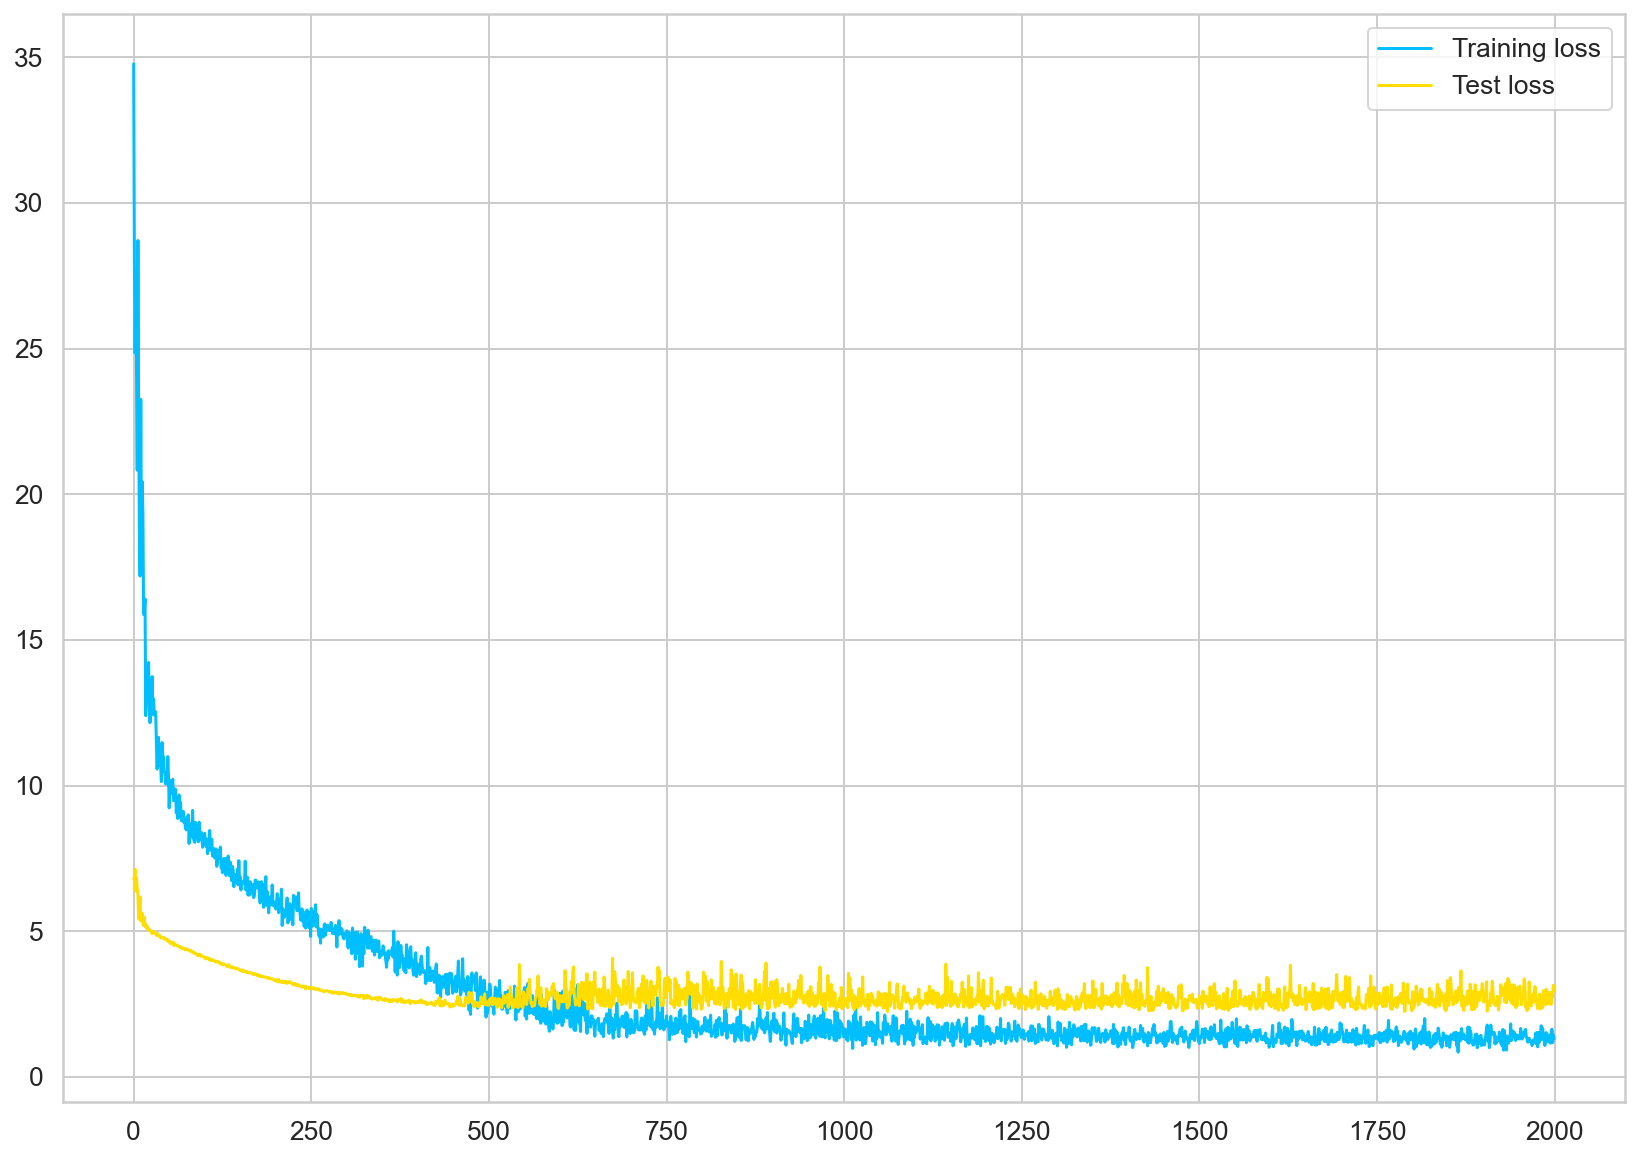

In [24]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
#plt.ylim((0, 5))
plt.legend()

### Predicting daily cases

In [26]:
with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [27]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)).flatten()

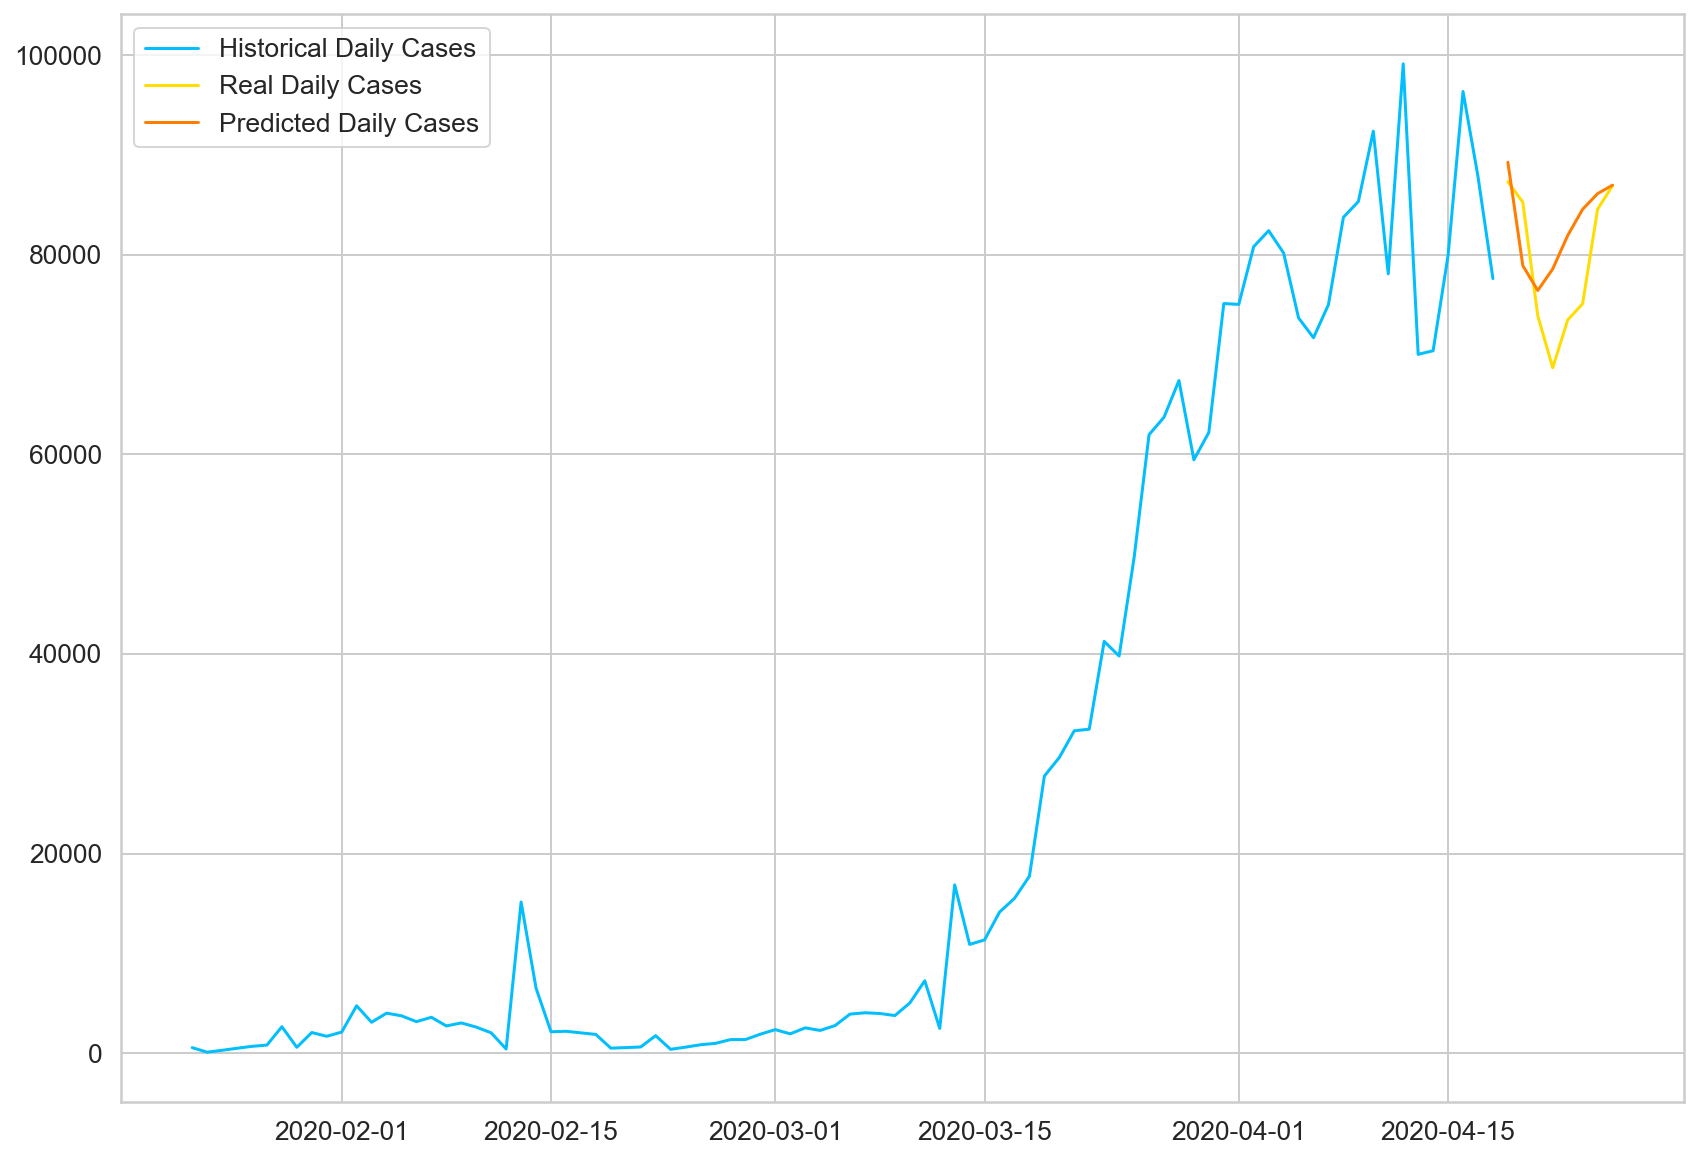

In [28]:
plt.plot(
          daily_cases.index[:len(train_data)], 
          scaler.inverse_transform(train_data).flatten(),
          label='Historical Daily Cases'
)

plt.plot(
          daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
          true_cases,
          label='Real Daily Cases'
)

plt.plot(
          daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
          predicted_cases, 
          label='Predicted Daily Cases'
)

plt.legend()

### Using all data for training

In [29]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(102, 1)

In [30]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
  n_features=1, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 32.6035
Epoch 10 train loss: 29.2833
Epoch 20 train loss: 16.3416
Epoch 30 train loss: 14.4916
Epoch 40 train loss: 12.3367
Epoch 50 train loss: 11.0746
Epoch 60 train loss: 10.6074
Epoch 70 train loss: 9.4397
Epoch 80 train loss: 9.4343
Epoch 90 train loss: 8.4990
Epoch 100 train loss: 8.0928
Epoch 110 train loss: 7.4149
Epoch 120 train loss: 7.0620
Epoch 130 train loss: 6.5520
Epoch 140 train loss: 6.2217
Epoch 150 train loss: 5.4956
Epoch 160 train loss: 5.3808
Epoch 170 train loss: 4.9803
Epoch 180 train loss: 5.1248
Epoch 190 train loss: 4.3694
Epoch 200 train loss: 4.0837
Epoch 210 train loss: 3.9143
Epoch 220 train loss: 3.5867
Epoch 230 train loss: 3.5121
Epoch 240 train loss: 3.3474
Epoch 250 train loss: 3.1507
Epoch 260 train loss: 2.8980
Epoch 270 train loss: 2.9254
Epoch 280 train loss: 2.7797
Epoch 290 train loss: 2.1993
Epoch 300 train loss: 2.6758
Epoch 310 train loss: 2.3277
Epoch 320 train loss: 2.0350
Epoch 330 train loss: 1.9544
Epoch 340 train lo

### Predicting Future Cases

In [31]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [32]:
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)).flatten()

In [33]:
daily_cases.index[-1]

Timestamp('2020-05-02 00:00:00')

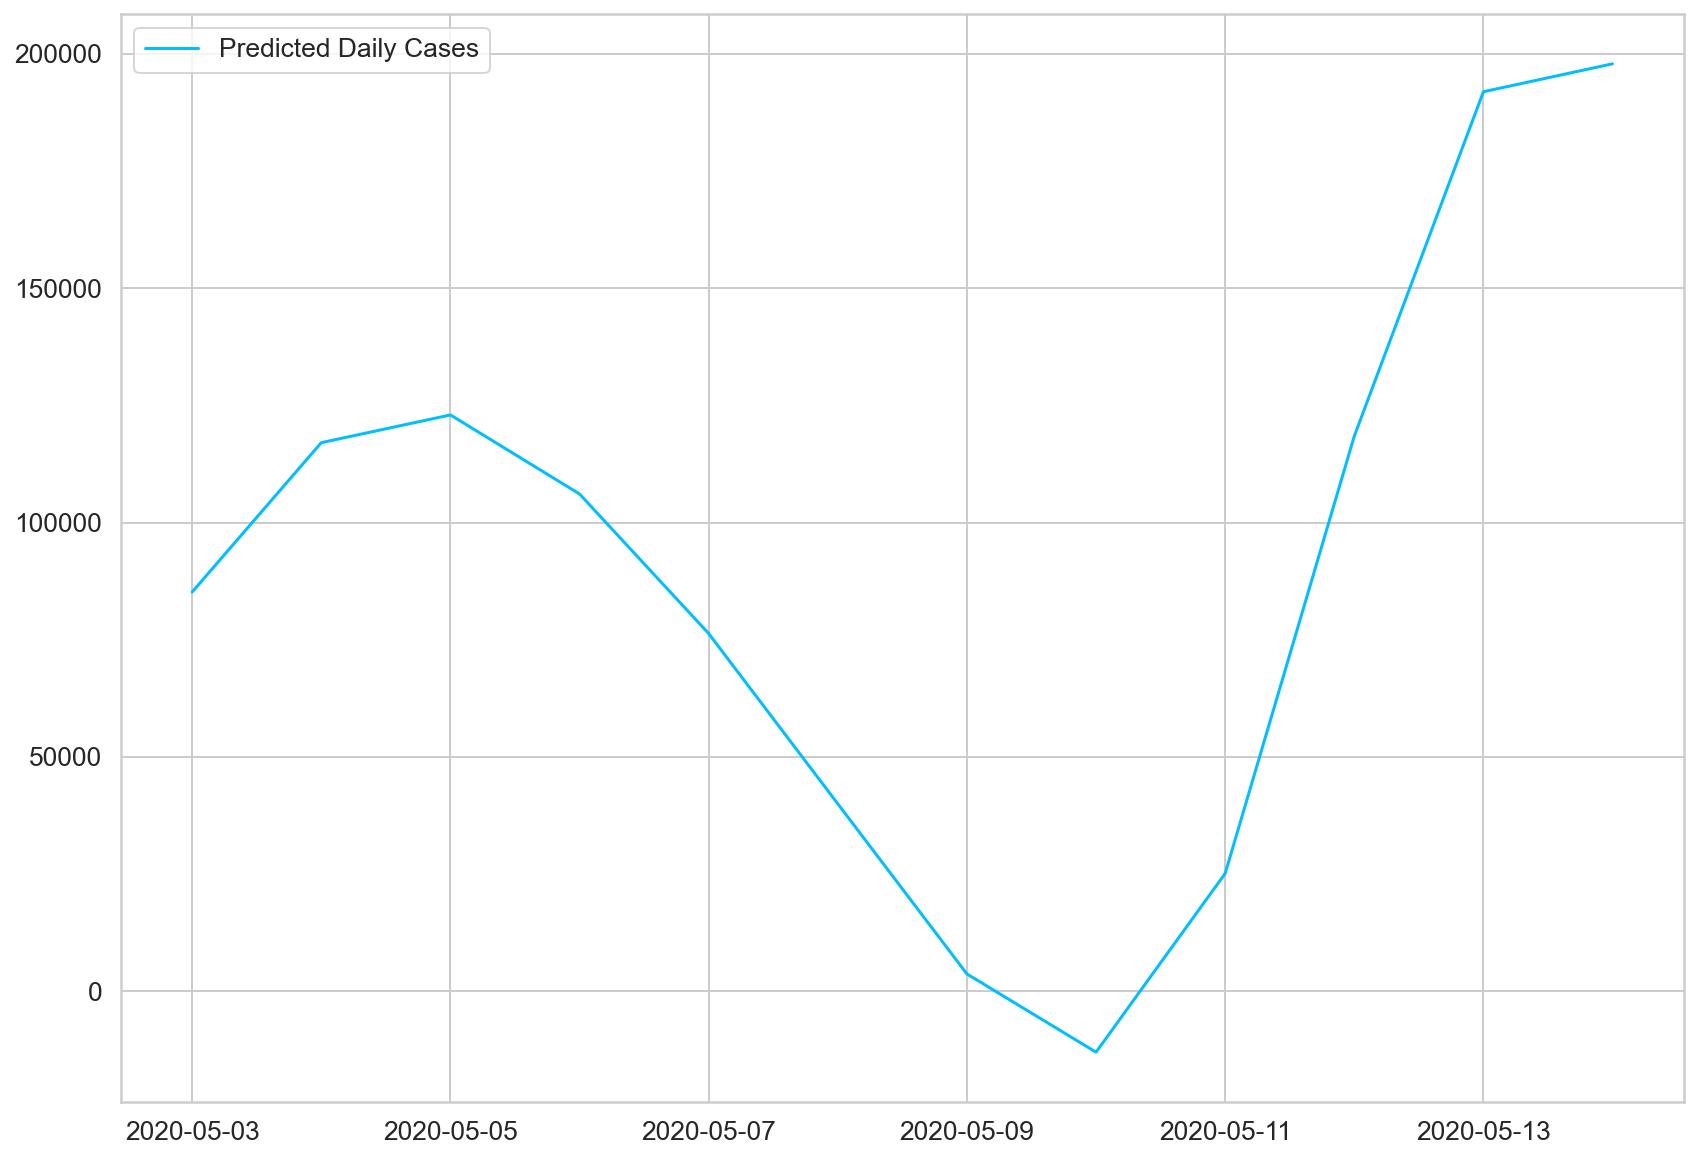

In [34]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right')

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

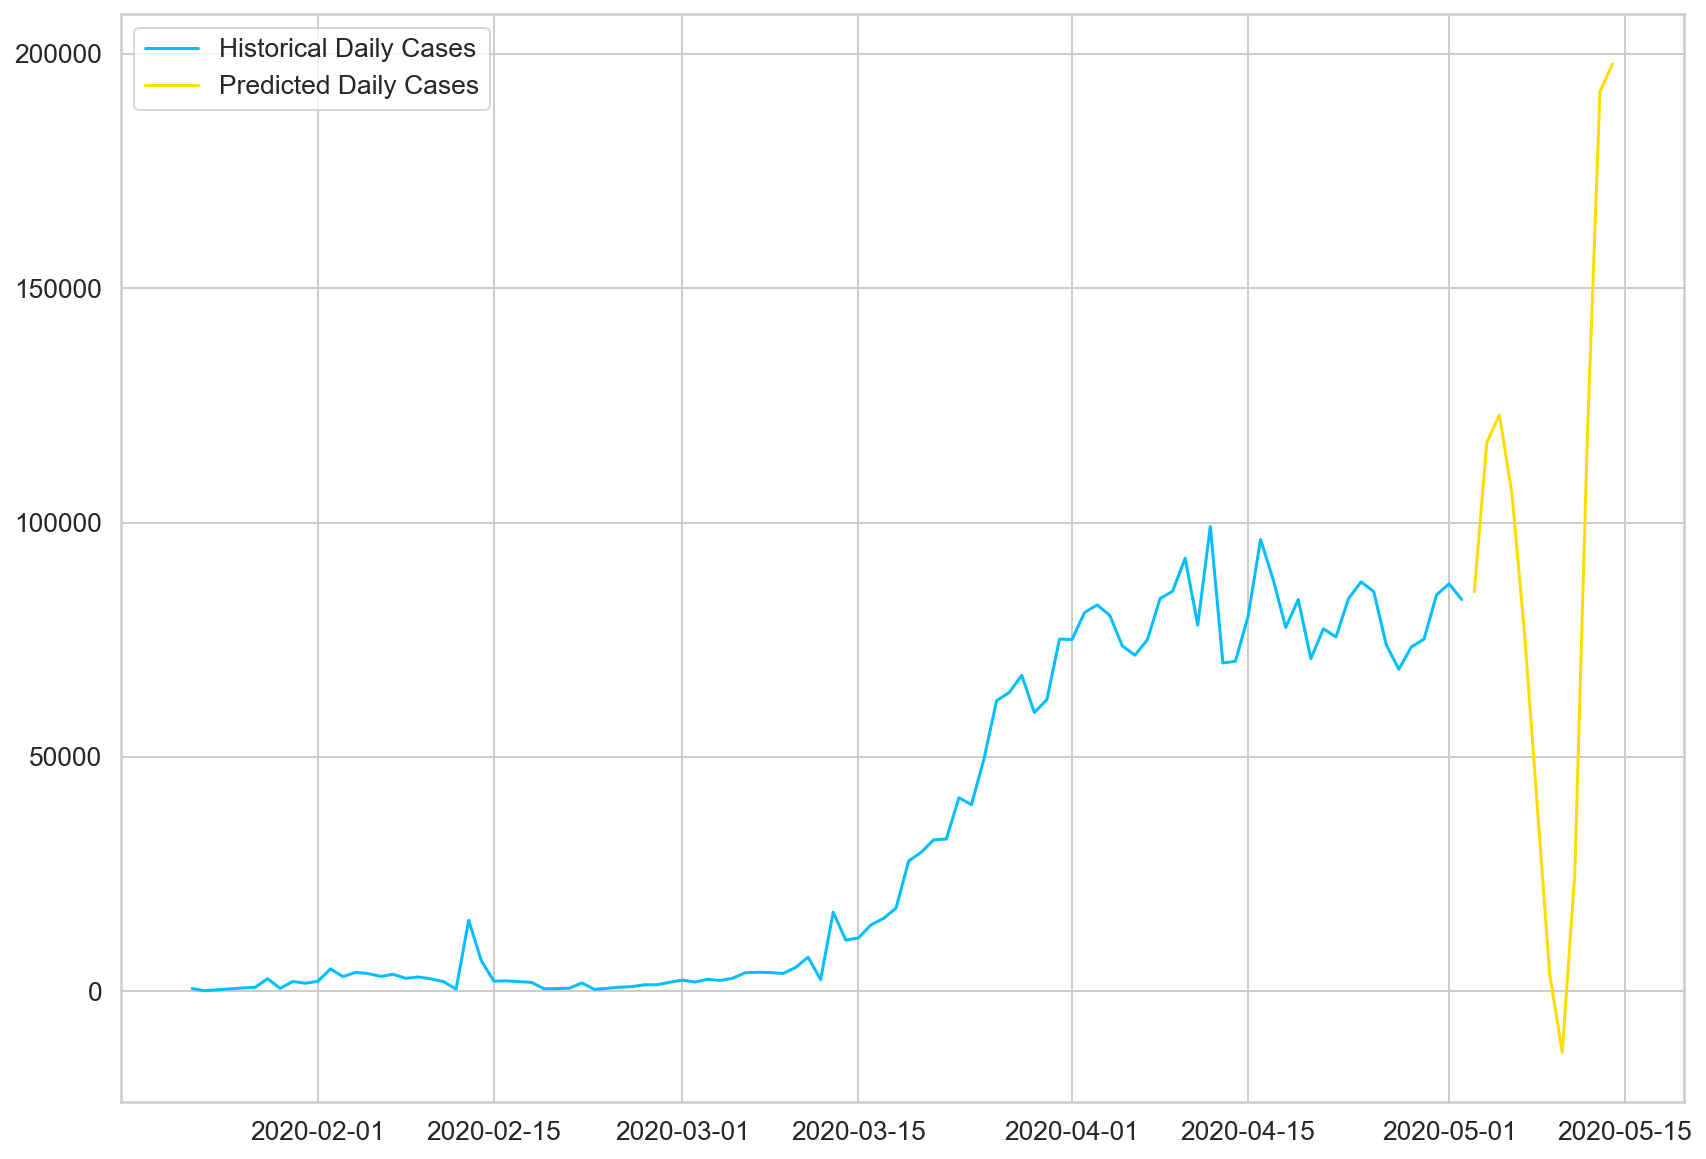

In [35]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

### References

- Sequence Models PyTorch Tutorial
- LSTM for time series prediction
- Time Series Prediction using LSTM with PyTorch in Python
- Stateful LSTM in Keras
- LSTMs for Time Series in PyTorch
- Novel Coronavirus (COVID-19) Cases, provided by JHU CSSE covid-19-analysis
- How does Coronavirus compare to Ebola, SARS, etc?
- Worldometer COVID-19 Coronavirus Outbreak
- How contagious is the Wuhan Coronavirus? (Ro)
- Systemic Risk of Pandemic via Novel Pathogens - Coronavirus: A Note Statistical Consequences of Fat Tails: Real World Preasymptotics, Epistemology, and Applications
- Time Series Forecasting with LSTMs for Daily Coronavirus Cases using PyTorch in Python